In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import copy
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score

In [19]:
data_transforms = {
    'train_class': transforms.Compose([
        transforms.RandomResizedCrop(112),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_class': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(112),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'emotions_ds'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train_class', 'val_class']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True)
              for x in ['train_class', 'val_class']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train_class', 'val_class']}
class_names = image_datasets['train_class'].classes

In [3]:
device = torch.device("cuda:0")

def train_model(base_model, criterion_loss, optimizer, num_epochs=5):

    best_model_wts = copy.deepcopy(base_model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        train_loss = 0.0
        test_loss = 0.0

        train_acc = 0
        test_acc = 0

        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        base_model.train()

        for img, labels in dataloaders['train_class']:
            #img, labels = img.cuda(), labels.cuda()
            img = img.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = base_model(img)
            loss = criterion_loss(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * img.size(0)
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(labels.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.cuda.FloatTensor))
            train_acc += accuracy.item() * img.size(0)
    
        base_model.eval()

        for img, labels in dataloaders['val_class']:
            #img, labels = img.cuda(), labels.cuda()
            img = img.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = base_model(img)
            loss = criterion_loss(output, labels)
            loss.backward()
            optimizer.step()
            test_loss += loss.item() * img.size(0)
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(labels.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.cuda.FloatTensor))
            test_acc += accuracy.item() * img.size(0)
    
        train_loss = train_loss / len(dataloaders['train_class'].dataset)
        test_loss = test_loss / len(dataloaders['val_class'].dataset)

        train_acc = train_acc / len(dataloaders['train_class'].dataset)
        test_acc = test_acc / len(dataloaders['val_class'].dataset)

        print(f'     Training Loss: {train_loss:.4f}, Training Accuracy: {100 * train_acc:.2f}')
        print(f'     Testing Loss: {test_loss:.4f}, Testing Accuracy: {100 * test_acc:.2f}')

    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = copy.deepcopy(base_model.state_dict())
    
    print(f'\nBest test Acc: {best_acc:.4f}')

    base_model.load_state_dict(best_model_wts)
    return base_model

In [4]:
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

n_classes = 8
n_inputs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

if torch.cuda.is_available():
    model.cuda()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [5]:
torch.cuda.memory_summary(device, abbreviated=False)
torch.cuda.empty_cache()
torch.ones((1500*2**18)).cuda(device).contiguous()
model = model.to(device)

In [6]:
model = train_model(model, criterion, optimizer)

Epoch 1/5
----------
     Training Loss: 2.0069, Training Accuracy: 21.51
     Testing Loss: 1.9329, Testing Accuracy: 24.85
Epoch 2/5
----------
     Training Loss: 1.9860, Training Accuracy: 22.42
     Testing Loss: 1.9083, Testing Accuracy: 25.65
Epoch 3/5
----------
     Training Loss: 1.9773, Training Accuracy: 23.15
     Testing Loss: 1.8848, Testing Accuracy: 26.10
Epoch 4/5
----------
     Training Loss: 1.9739, Training Accuracy: 23.12
     Testing Loss: 1.8772, Testing Accuracy: 26.80
Epoch 5/5
----------
     Training Loss: 1.9734, Training Accuracy: 23.38
     Testing Loss: 1.8655, Testing Accuracy: 28.48

Best test Acc: 0.2848


In [7]:
def predict():
    test_acc = 0
    test_acc = 0
    real_lab = torch.tensor([]).to(device)
    pred_lab = torch.tensor([]).to(device)
    tr_pred =  []

    for batch, (X, y) in enumerate(dataloaders['val_class']):
        X, y = X.to(device), y.to(device)
        real_lab = torch.cat((real_lab, y), 0)
        pred = model(X)
        _, pred = torch.max(pred, dim=1)
        pred_lab = torch.cat((pred_lab, pred), 0)

        correct_tensor = pred.eq(y.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.cuda.FloatTensor))
        test_acc += accuracy.item()* X.size(0)
    
    test_acc = test_acc / len(dataloaders['val_class'].dataset)
    print(f'    Testing Accuracy: { test_acc:.2f}')
    return pred_lab.cpu().numpy(),  real_lab.cpu().numpy()

all_pr,  real_lab = predict()

    Testing Accuracy: 0.31


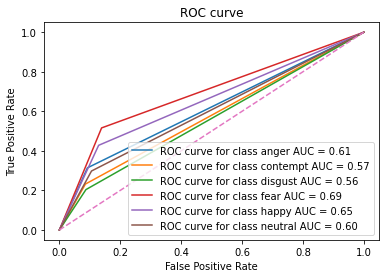

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
lab_plt = [(real_lab == i).astype(float) for i in range(6)]
outs_plt = [(all_pr == i).astype(float) for i in range(6)]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(lab_plt[i], outs_plt[i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.title('ROC curve')
for i in range(6):
    plt.plot(fpr[i], tpr[i], label = f'ROC curve for class {class_names[i]} AUC = {roc_auc[i]:.2f}' )
plt.legend(loc = 'best')
plt.plot([0,1], [0,1], linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [9]:

print(classification_report(real_lab,all_pr, target_names=class_names))

              precision    recall  f1-score   support

       anger       0.33      0.31      0.32       500
    contempt       0.28      0.23      0.25       500
     disgust       0.25      0.20      0.22       500
        fear       0.35      0.52      0.42       500
       happy       0.32      0.43      0.37       500
     neutral       0.29      0.30      0.29       500
         sad       0.33      0.19      0.24       500
    surprise       0.31      0.30      0.30       500

    accuracy                           0.31      4000
   macro avg       0.31      0.31      0.30      4000
weighted avg       0.31      0.31      0.30      4000



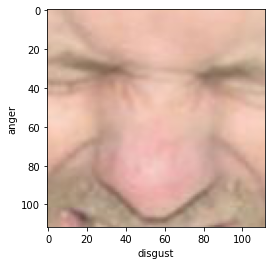

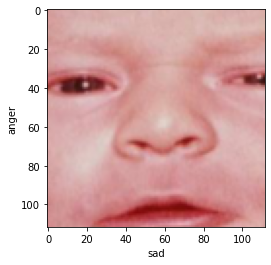

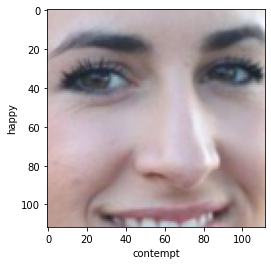

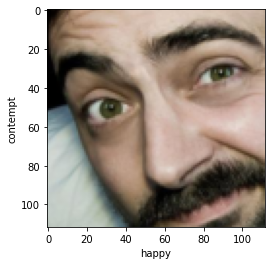

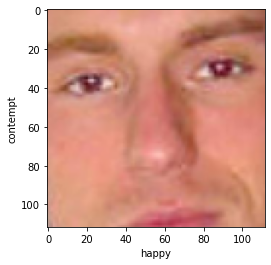

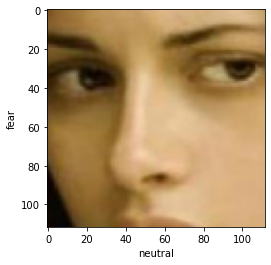

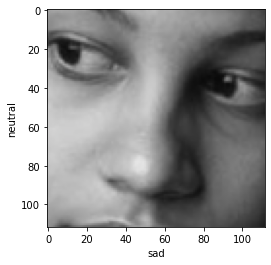

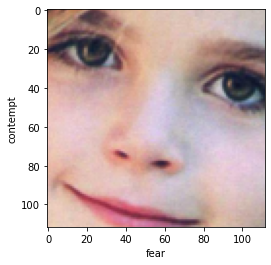

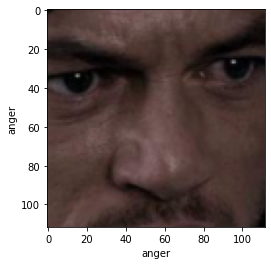

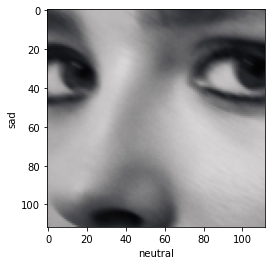

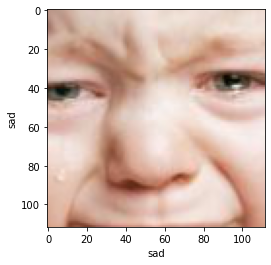

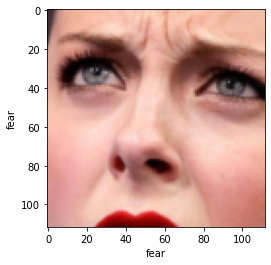

In [20]:
def plot_img(n):
    count = 0
    for img, lab in dataloaders['val_class']:
        count += 1 
        image = img 
        img = img.to(device)
        pred = model(img)
        _, pred = torch.max(pred, dim=1)
        for i in range(4):
            inp = torchvision.utils.make_grid(image[i]).numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)
            plt.ylabel(class_names[lab[i]])
            plt.xlabel(class_names[pred[i]])
            plt.show()
        if count == n:
            break

plot_img(3)

Conclusion

I think low accuracy is caused by a bad set of photos. In some of the photographs, people cover their faces with something. Also, not always turned to the camera. This complicates the learning process. 